# SEG/EAGE 3-D Salt Model

In this notebook we reproduce the results by Mulder, 2007, which uses the salt from Aminzadeh et al., 1997.

### IMPORTANT
The SEG is working on making this dataset open-source, and I expect it will be online within a few weeks. However, until then you need the original data to reproduce this example, sorry. I will post it here once the data is available online.


## Velocity to resistivity transform

Quoting here the description of the velocity-to-resistivity transform used by Mulder, 2007: 

> *"The SEG/EAGE salt model (Aminzadeh et al. 1997), originally designed for seismic simulations, served as a template for a realistic subsurface model. Its dimensions are 13500 by 13480 by 4680 m. The seismic velocities of the model were replaced by resistivity values. The water velocity of 1.5 km/s was replaced by a resistivity of 0.3 Ohm m. Velocities above 4 km/s, indicative of salt, were replaced by 30 Ohm m. Basement, beyond 3660 m depth, was set to 0.002 Ohm m. The resistivity of the sediments was determined by (v/1700) 3.88 Ohm m, with the velocity v in m/s (Meju et al. 2003). For air, the resistivity was set to 10 8 Ohm m."*

Equation 1 of Meju et al., 2003, is given by
$$ \log_{10}\rho = m \log_{10}V_P + c \ ,$$
where $\rho$ is resistivity, $V_P$ is P-wave velocity, and for $m$ and $c$ 3.88 and -11 were used, respectively.

The velocity-to-resistivity transform uses therefore a Faust model (Faust, 1953) with some additional constraints for water, salt, and basement.

### References
- **Aminzadeh, F., Brac, J., and Kunz, T., 1997**, SEG/EAGE 3-D Salt and Overthrust Models, Society of Exploration Geophysicists, Tulsa, Oklahoma.
- **Meju, M. A., L. A. Gallardo, and A. K. Mohamed, 2003**, Evidence for correlation of electrical resistivity and seismic velocity in heterogeneous near-surface materials: Geophysical Research Letters, 30, 26-1‒26-4; doi: [10.1029/2002GL016048](https://doi.org/10.1029/2002GL016048).  
- **Faust, L. Y., 1953**, A velocity function including lithologic variation: Geophysics, 18, 271‒288; doi: [10.1190/1.1437869](https://doi.org/10.1190/1.1437869).  
- **Mulder, W. A., 2007**, A robust solver for CSEM modelling on stretched grids: EAGE Technical Program Expanded Abstracts, D036; doi: [10.3997/2214-4609.201401567](https://doi.org/10.3997/2214-4609.201401567).

In [1]:
import vtki
import joblib
import discretize
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d as e3d

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load model; Velocity to resistivity transform

In [3]:
try:
    # Get resistivities if we already calculated them
    res = joblib.load('./data/SEG-EAGE/res-model.lzma')

    # Get dimension
    nx, ny, nz = res.shape

except:  # THE ORIGINAL DATA ARE REQUIRED TO GENERATE THE RESISTIVITIES!

    # Dimensions
    nx, ny, nz = 676, 676, 210

    # Load data
    with open('./data/SEG-EAGE/VEL_GRIDS/Saltf@@', 'r') as file:
        v = np.fromfile(file, dtype=np.dtype('float32').newbyteorder('>'))
        v = v.reshape(nx, ny, nz, order='F')

    # Velocity to resistivity transform for whole cube
    res = (v/1700)**3.88  # Sediment resistivity = 1

    # Overwrite basement resistivity from 3660 m onwards
    res[:, :, np.arange(nz)*20 > 3660] = 500.  # Resistivity of basement

    # Set sea-water to 0.3
    res[:, :, :15][v[:, :, :15] <= 1500] = 0.3

    # Fix salt resistivity
    res[v == 4482] = 30.
    
    # Save it in compressed form
    # THE SEG/EAGE salt-model uses positive z downwards; discretize positive upwards. Hence:
    # => for res, use np.flip(res, 2) to flip the z-direction
    #joblib.dump(res, './res-model', compress=True)  # Very fast, but not so effective (118.6 MB).
    joblib.dump(np.flip(res, 2), './data/res-model.lzma')  # lzma: very slow, but very effective (~ 18.6 MB).
    
# Create a discretize-mesh
mesh = discretize.TensorMesh([np.ones(nx)*20., np.ones(ny)*20., np.ones(nz)*20.], x0='00N')
models = {'res': np.log10(res.ravel('F'))}

# Limit colour-range
# We're cutting here the colour-spectrum at 50 Omega.m (affects only
# the basement) to have a better resolution in the sediments.
clim = np.log10([np.nanmin(res), 50])

mesh

TensorMesh: 95,964,960 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    676          0.00     13,520.00     20.00     20.00    1.00
   y    676          0.00     13,520.00     20.00     20.00    1.00
   z    210     -4,200.00          0.00     20.00     20.00    1.00

## 3D-slicer

<IPython.core.display.Javascript object>


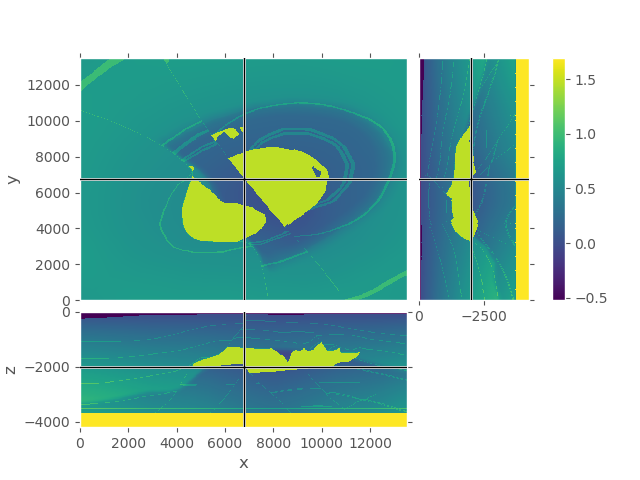

In [4]:
mesh.plot_3d_slicer(models['res'], zslice=-2000, clim=clim)

## `vtki`-plot

Create an interactive 3D render of the data.

In [5]:
# Get the ``vtki`` dataset of the inverted model
dataset = mesh.toVTK(models)

# Create the rendering scene and add a grid axes
p = vtki.Plotter(notebook=False)
p.add_bounds_axes(grid=True, location='outer')

xyz = (5000, 6000, -3200)
p.add_mesh(dataset.slice('x', xyz), rng=clim, name='x-slice', cmap='viridis', show_edges=False)
p.add_mesh(dataset.slice('y', xyz), rng=clim, name='y-slice', cmap='viridis', show_edges=False)
p.add_mesh(dataset.slice('z', xyz), rng=clim, name='z-slice', cmap='viridis', show_edges=False)

# Get the salt body
p.add_mesh(dataset.threshold([1.47, 1.48]), rng=clim, name='vol', cmap='viridis', show_edges=False)

# Show the scene!
pos = [(26520.02642819169, 36943.98836760165, 5845.156497305449),
    (6592.195458439808, 6616.294146605825, -3324.7436511166616),
    (-0.1511030631341394, -0.19380116219677365, 0.969334294164124)]
p.camera_position = pos

p.show(auto_close=False)

# Finally, close the plotter.
p.close()

# Forward modelling

## Survey parameters

In [6]:
src = [6400, 6600, 6500, 6500, -50, -50]  # source location
freq = 1.0                                # Frequency

## Initialize calculation mesh

In [7]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = e3d.utils.get_domain(x0=6500, freq=freq, limits=[0, 13500], min_width=[5, 100])
hz_min, zdomain = e3d.utils.get_domain(freq=freq, limits=[-4180, 0], min_width=[5, 20], fact_pos=40)

# Create stretched grid
nx = 2**7
hx = e3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hy = e3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hz = e3d.utils.get_stretched_h(hz_min, zdomain, nx, x0=-100, x1=0)
grid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
grid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128          0.00     13,482.75     55.13    182.61    1.02
   y    128          0.00     13,482.75     55.13    182.61    1.02
   z    128     -4,180.00     11,250.16     20.00    516.82    1.05

## Put the salt model onto the modelling mesh

In [8]:
fn = si.RegularGridInterpolator(
    (mesh.vectorCCx, mesh.vectorCCy, mesh.vectorCCz),
    res, bounds_error=False, fill_value=None)
cres = fn(grid.gridCC, method='linear')

<IPython.core.display.Javascript object>


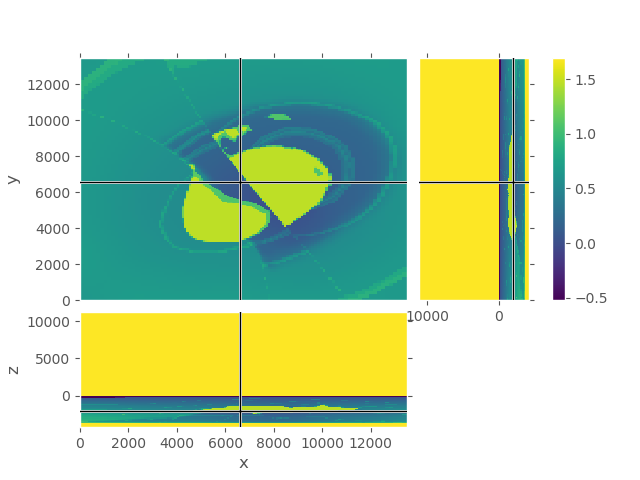

In [9]:
# Create model
model = e3d.utils.Model(grid, cres, cres, cres, freq)

# Set air resistivity
iz = np.argmin(np.abs(grid.vectorNz))
model.res_x[:, :, iz:] = 1e6 #2e14
model.res_y[:, :, iz:] = 1e6 #2e14
model.res_z[:, :, iz:] = 1e6 #2e14

# Ensure at least top layer is water
model.res_x[:, :, iz] = 0.3
model.res_y[:, :, iz] = 0.3
model.res_z[:, :, iz] = 0.3

cmodels = {'res': np.log10(model.res_x.ravel('F'))}

grid.plot_3d_slicer(cmodels['res'], zslice=-2000, clim= np.log10([np.nanmin(model.res), 50]))# , transparent='slider')

In [10]:
dataset = grid.toVTK(cmodels)
dataset = dataset.clip_box(bounds=(0, 13500, 0, 13500, -4000, 0), invert=False)

# Create the rendering scene and add a grid axes
p = vtki.Plotter(notebook=False)
p.add_bounds_axes(grid=True, location='outer')


# Add spatially referenced data to the scene
xyz = (5000, 6000, -3200)
p.add_mesh(dataset.slice('x', xyz), rng=clim, name='x-slice', cmap='viridis', show_edges=False)
p.add_mesh(dataset.slice('y', xyz), rng=clim, name='y-slice', cmap='viridis', show_edges=False)
p.add_mesh(dataset.slice('z', xyz), rng=clim, name='z-slice', cmap='viridis', show_edges=False)

# Get the salt body
p.add_mesh(dataset.threshold([1.47, 1.48]), rng=clim, name='vol', cmap='viridis', show_edges=False)

# Show the scene!
pos = [(26520.02642819169, 36943.98836760165, 5845.156497305449),
    (6592.195458439808, 6616.294146605825, -3324.7436511166616),
    (-0.1511030631341394, -0.19380116219677365, 0.969334294164124)]
p.camera_position = pos

p.show(auto_close=False)

# Finally, close the plotter.
p.close()

## Solve the system

In [11]:
# Source field
sfield = e3d.utils.get_source_field(grid, src, freq, 0)

pfield = e3d.solver.solver(grid, model, sfield, sslsolver=True, semicoarsening=True, linerelaxation=True, verb=3)


:: emg3d START :: 14:56:43 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error          solver               MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/      

   [14:57:43] 1.170e-08 after                       1 F-cycles;   4 1
   [14:58:21] 4.036e-10 after                       2 F-cycles;   5 2
   [14:59:05] 8.301e-11 after              

<IPython.core.display.Javascript object>


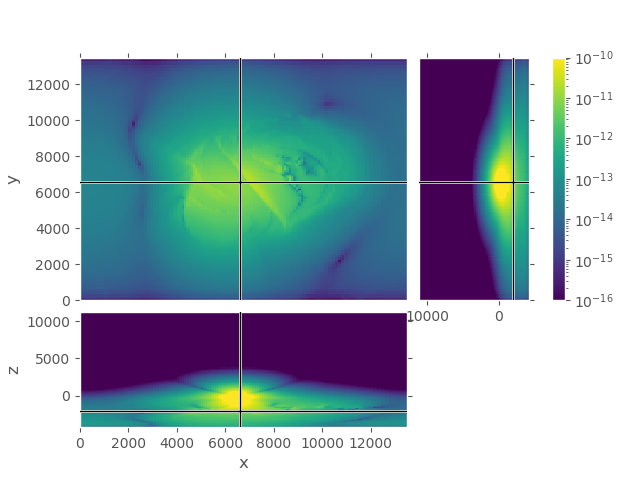

In [12]:
grid.plot_3d_slicer(pfield, zslice=-2000, view='abs', vType='Ex', clim=[1e-16, 1e-10], pcolorOpts={'norm': LogNorm()})

# grid.plot_3d_slicer(pfield, zslice=-2000, view='imag', vType='Ex',
#                     pcolorOpts={'norm': SymLogNorm(linthresh=1e-14)}, clim=[-1e-6, 1e-6])

<IPython.core.display.Javascript object>


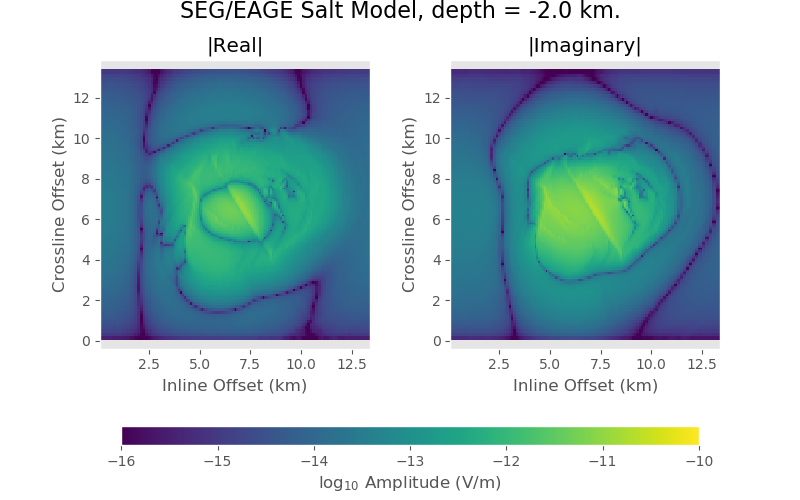

In [13]:
# Interpolate for a "more detailed" image
x = grid.vectorCCx
y = grid.vectorCCy
rx = np.repeat([x, ], np.size(x), axis=0)
ry = rx.transpose()
rz = -2000
data = si.interpn((grid.vectorCCx, grid.vectorNy, grid.vectorNz), pfield.fx, (rx, ry, rz))

# Colour limits
vmin, vmax = -16, -10

# Create a figure
fig, axs = plt.subplots(figsize=(8, 5), nrows=1, ncols=2)
axs = axs.ravel()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

titles = [r'|Real|', r'|Imaginary|']
dat = [np.log10(np.abs(data.real)), np.log10(np.abs(data.imag))]

for i in range(2):
    plt.sca(axs[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlim(min(x)/1000, max(x)/1000)
    axs[i].set_ylim(min(x)/1000, max(x)/1000)
    axs[i].axis('equal')
    cs = axs[i].pcolormesh(x/1000, x/1000, dat[i], vmin=vmin, vmax=vmax, linewidth=0, rasterized=True,)
    plt.xlabel('Inline Offset (km)')
    plt.ylabel('Crossline Offset (km)')

# Colorbar
#fig.colorbar(cf0, ax=axs[0], label=r'$\log_{10}$ Amplitude (V/m)')

# Plot colorbar
cax, kw = plt.matplotlib.colorbar.make_axes(axs, location='bottom',
                                            fraction=.05, pad=0.2, aspect=30)
cb = plt.colorbar(cs, cax=cax, label=r"$\log_{10}$ Amplitude (V/m)", **kw)


# Title
fig.suptitle(f"SEG/EAGE Salt Model, depth = {rz/1e3} km.", y=1, fontsize=16)

plt.show()

In [14]:
e3d.Versions([discretize, vtki])

------------------------------------------------------
  Tue Apr 30 15:02:46 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.3 : numpy
          1.2.1 : scipy
         0.43.1 : numba
      0.5.0dev0 : emg3d
          7.5.0 : IPython
          3.0.3 : matplotlib
          0.4.2 : discretize
         0.17.0 : vtki

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------